In [1]:
import tensorflow as tf
# from tensorflow.keras import layers, Model
from keras import layers, Model
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

In [2]:
# 1. Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # add channel dim: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # (10000, 28, 28, 1)

In [ ]:
# 2. Create CCN to extract features
NO_DIMS = 64
def create_base_network():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(NO_DIMS, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(NO_DIMS * 2, activation='relu')(x)
    x = layers.Dense(NO_DIMS, name='embedding')(x)  # Embedding 64 dim
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)  # L2
    return Model(inputs, x)

base_network = create_base_network()
base_network.summary()

2025-04-06 01:27:08.618450: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-04-06 01:27:08.618472: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-06 01:27:08.618478: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-04-06 01:27:08.618496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-06 01:27:08.618509: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,000 (906.25 KB)

 Trainable params: 232,000 (906.25 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 3. create triplet set
def create_triplets(x, y, num_triplets=1000):
    triplets = []
    for _ in range(num_triplets):
        # Random Anchor and Positive (same labels)
        anchor_idx = np.random.randint(0, len(x))
        positive_idx = np.random.choice(np.where(y == y[anchor_idx])[0])
        # Random Negative (diff labels)
        negative_idx = np.random.choice(np.where(y != y[anchor_idx])[0])
        triplets.append((x[anchor_idx], x[positive_idx], x[negative_idx]))
    return triplets

# Create triplet set from training set
triplets = create_triplets(x_train, y_train, num_triplets=5000)
anchor_images = np.array([t[0] for t in triplets])
positive_images = np.array([t[1] for t in triplets])
negative_images = np.array([t[2] for t in triplets])

In [ ]:
# 4. Triplet Loss
def triplet_loss(y_true, y_pred, alpha=0.5):
    anchor, positive, negative = y_pred[:, 0:NO_DIMS], y_pred[:, NO_DIMS:NO_DIMS*2], y_pred[:, NO_DIMS*2:]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    loss = tf.maximum(pos_dist - neg_dist + alpha, 0.0)
    return tf.reduce_mean(loss)

In [6]:
# 5. Create triplet model
anchor_input = layers.Input(shape=(28, 28, 1), name='anchor')
positive_input = layers.Input(shape=(28, 28, 1), name='positive')
negative_input = layers.Input(shape=(28, 28, 1), name='negative')

anchor_embedding = base_network(anchor_input)
positive_embedding = base_network(positive_input)
negative_embedding = base_network(negative_input)

merged_output = layers.Concatenate(axis=1)([anchor_embedding, positive_embedding, negative_embedding])
triplet_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)
triplet_model.compile(optimizer='adam', loss=triplet_loss)

In [7]:
# 6. train model
triplet_model.fit(
    [anchor_images, positive_images, negative_images],
    np.zeros((len(anchor_images),)),  # y_true does not need, match to API only
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10


2025-04-06 01:27:09.817773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-06 01:27:09.820374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1243
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0307
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0159
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0080
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0060
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0032
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.9648e-04
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0035
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0020


In [8]:
# 7. save embedding of reference set
NO_SAMPLES = 1_000
reference_images = x_train[:NO_SAMPLES]  # get 100 samples to refer
reference_labels = y_train[:NO_SAMPLES]
reference_embeddings = base_network.predict(reference_images)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [9]:
# 8. predict new one without re-train
def recognize_digit(new_image, reference_embeddings, reference_labels):
    new_embedding = base_network.predict(np.expand_dims(new_image, axis=0))
    distances = euclidean_distances(new_embedding, reference_embeddings)[0]
    nearest_idx = np.argmin(distances)
    predicted_label = reference_labels[nearest_idx]
    return predicted_label, distances[nearest_idx]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
True Label: 9, Predicted Label: 9, Distance: 0.2124


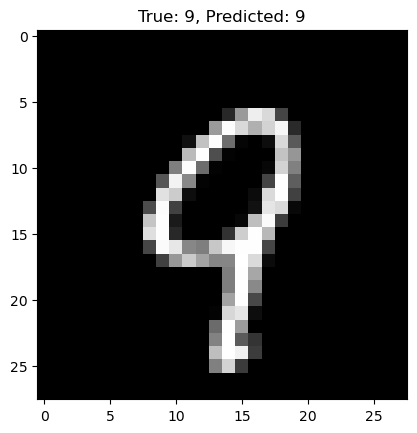

In [10]:
# try to predict new from test set
rand_idx = np.random.randint(0, len(x_test))
new_image = x_test[rand_idx]
true_label = y_test[rand_idx]
predicted_label, distance = recognize_digit(new_image, reference_embeddings, reference_labels)
print(f"True Label: {true_label}, Predicted Label: {predicted_label}, Distance: {distance:.4f}")

# 9. visualize
plt.imshow(new_image.squeeze(), cmap='gray')
plt.title(f"True: {true_label}, Predicted: {predicted_label}")
plt.show()